In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = "/Users/michelangelozampieri/Desktop/TAMID-Group-New/data/sorted_data_output"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_eval)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class_names = train_dataset.classes
num_classes = len(class_names)

model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Regularization
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

In [8]:
from tqdm import tqdm  # Import tqdm for progress bars

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm description with loss and accuracy
            pbar.set_postfix(loss=running_loss / (total / labels.size(0)), accuracy=100. * correct / total)

    # Update learning rate
    scheduler.step()
    # Calculate average loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%")


Training Epoch 1/10: 100%|██████████| 51/51 [07:05<00:00,  8.34s/batch, accuracy=58.1, loss=0.197]


Epoch [1/10], Loss: 1.0331, Val Acc: 63.82%


Training Epoch 2/10: 100%|██████████| 51/51 [23:00<00:00, 27.07s/batch, accuracy=64.4, loss=0.171] 


Epoch [2/10], Loss: 0.8986, Val Acc: 71.51%


Training Epoch 3/10: 100%|██████████| 51/51 [08:30<00:00, 10.01s/batch, accuracy=65.7, loss=0.158]


Epoch [3/10], Loss: 0.8318, Val Acc: 62.96%


Training Epoch 4/10: 100%|██████████| 51/51 [08:11<00:00,  9.63s/batch, accuracy=67.7, loss=0.149]


Epoch [4/10], Loss: 0.7841, Val Acc: 76.92%


Training Epoch 5/10: 100%|██████████| 51/51 [07:28<00:00,  8.80s/batch, accuracy=67.8, loss=0.147]


Epoch [5/10], Loss: 0.7722, Val Acc: 70.94%


Training Epoch 6/10: 100%|██████████| 51/51 [20:46<00:00, 24.44s/batch, accuracy=71.9, loss=0.132]   


Epoch [6/10], Loss: 0.6907, Val Acc: 83.19%


Training Epoch 7/10: 100%|██████████| 51/51 [07:09<00:00,  8.43s/batch, accuracy=75.5, loss=0.121]


Epoch [7/10], Loss: 0.6348, Val Acc: 81.48%


Training Epoch 8/10: 100%|██████████| 51/51 [26:11<00:00, 30.81s/batch, accuracy=77.7, loss=0.113]  


Epoch [8/10], Loss: 0.5913, Val Acc: 84.05%


Training Epoch 9/10: 100%|██████████| 51/51 [24:47<00:00, 29.17s/batch, accuracy=77.6, loss=0.111]   


Epoch [9/10], Loss: 0.5823, Val Acc: 86.89%


Training Epoch 10/10: 100%|██████████| 51/51 [07:54<00:00,  9.30s/batch, accuracy=78, loss=0.109]  


Epoch [10/10], Loss: 0.5697, Val Acc: 82.05%


In [9]:
# Testing phase
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

       Other       0.00      0.00      0.00         6
       PE-HD       0.78      0.32      0.45        22
         PET       0.98      0.95      0.96       193
          PP       0.53      0.37      0.43        54
          PS       0.53      0.95      0.68        55
         PVC       1.00      0.84      0.91        19

    accuracy                           0.80       349
   macro avg       0.63      0.57      0.57       349
weighted avg       0.81      0.80      0.78       349


Confusion Matrix:
[[  0   0   0   0   6   0]
 [  0   7   0   9   6   0]
 [  0   0 183   6   4   0]
 [  0   0   3  20  31   0]
 [  0   0   0   3  52   0]
 [  0   2   1   0   0  16]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
torch.save(model, 'improved_resnet18_model.pth')

In [11]:
def predict_and_compare(image_path, model, class_names, transform, true_class=None, device='cuda'):
    from PIL import Image
    import matplotlib.pyplot as plt
    import torch

    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]

    # Display the image with prediction
    plt.imshow(image)
    title = f"Predicted: {predicted_class}"
    if true_class:
        title += f" | Actual: {true_class}"
    plt.title(title)
    plt.axis('off')
    plt.show()

    return predicted_class, true_class


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

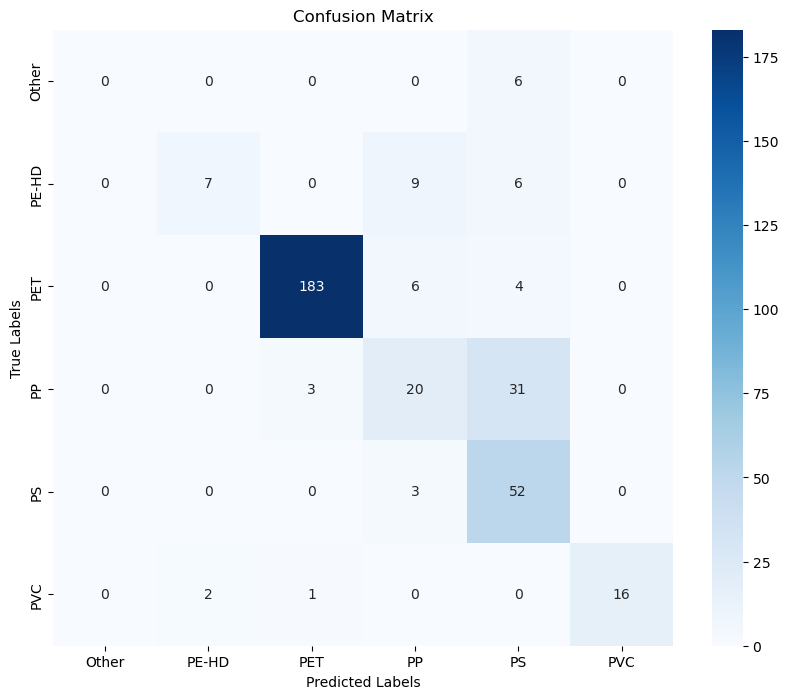

In [14]:
plot_confusion_matrix(model, test_loader, class_names, device)

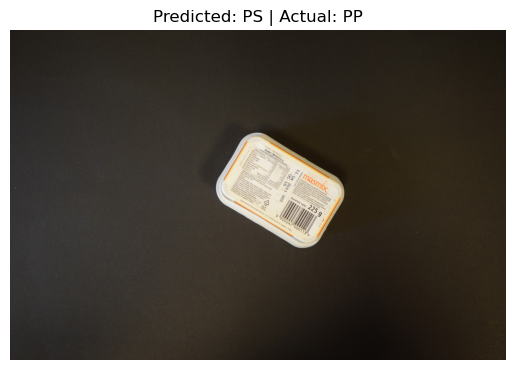

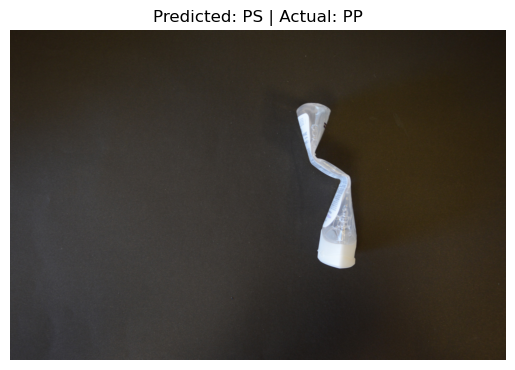

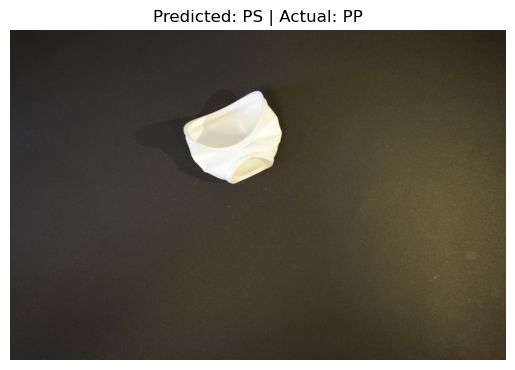

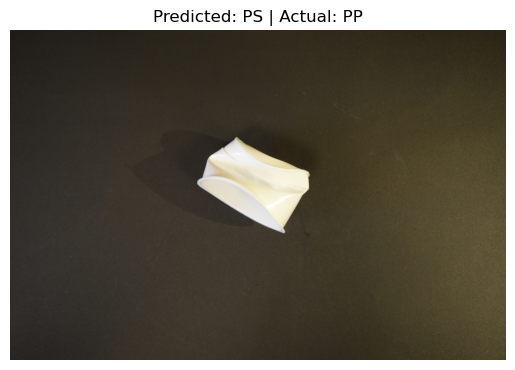

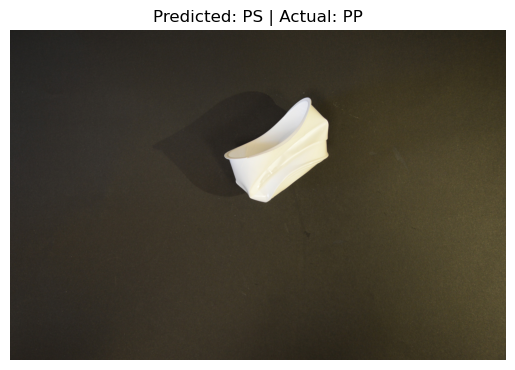

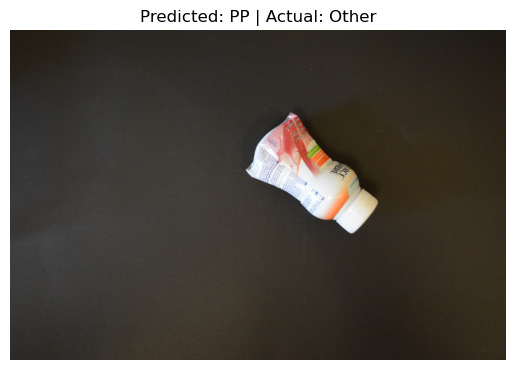

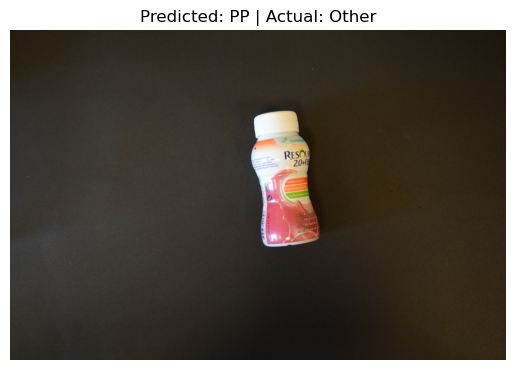

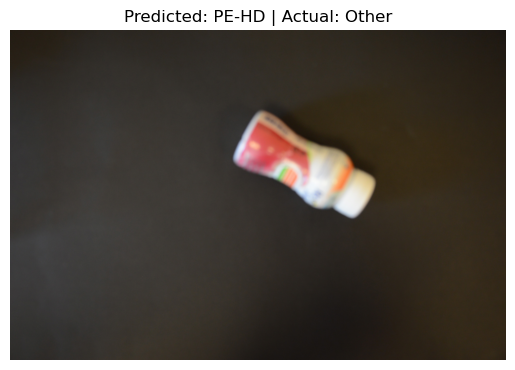

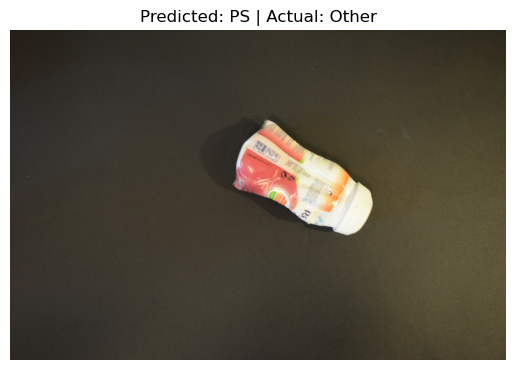

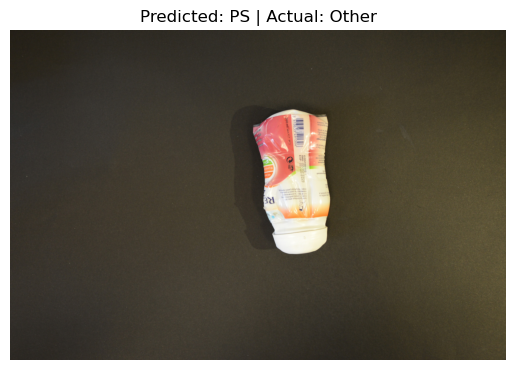

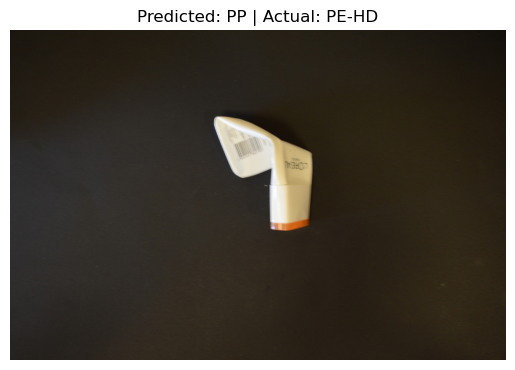

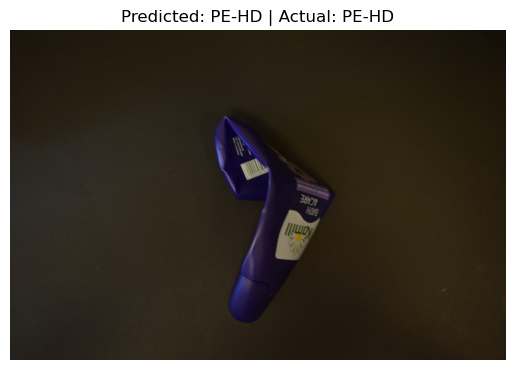

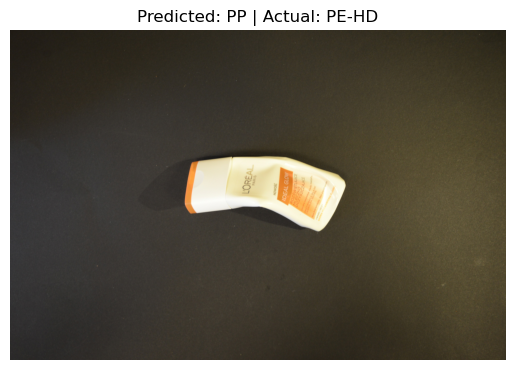

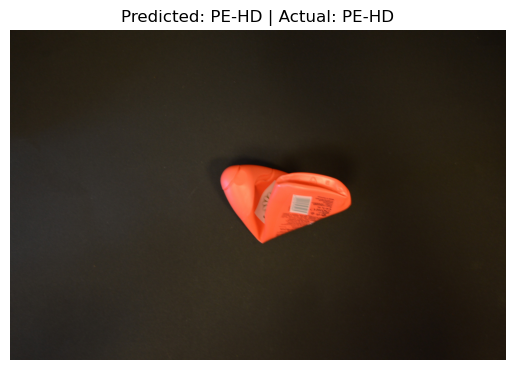

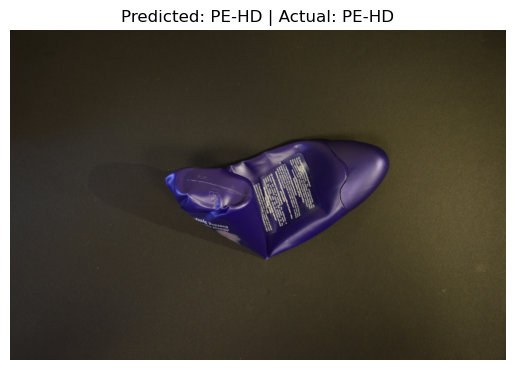

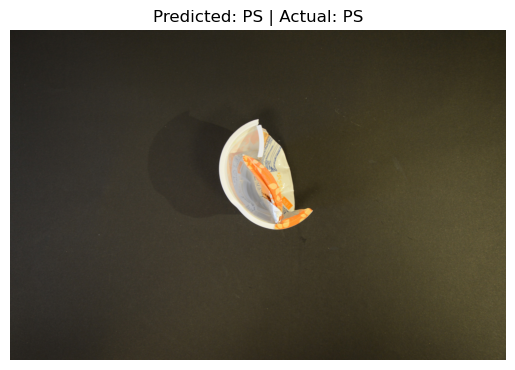

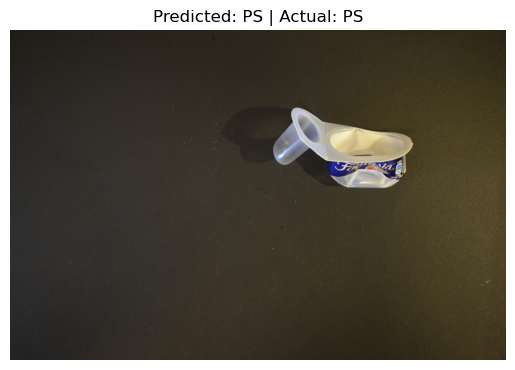

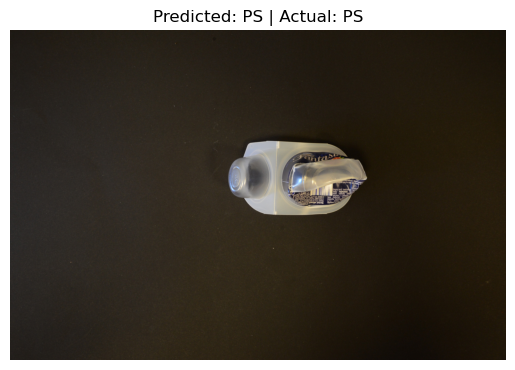

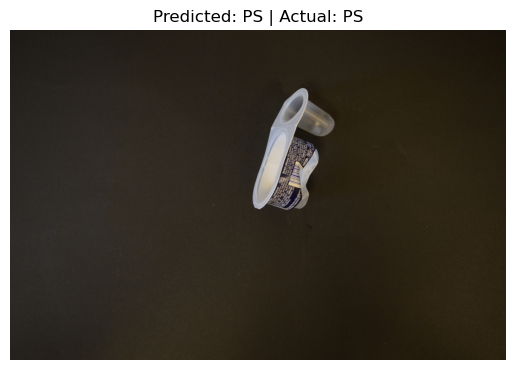

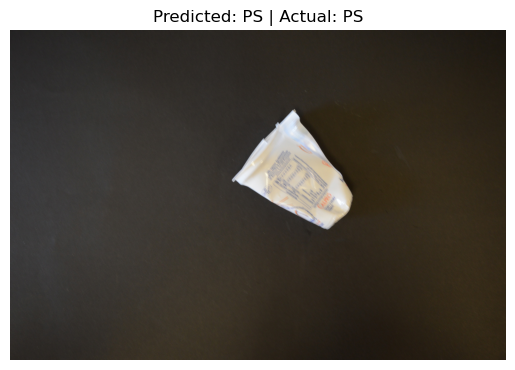

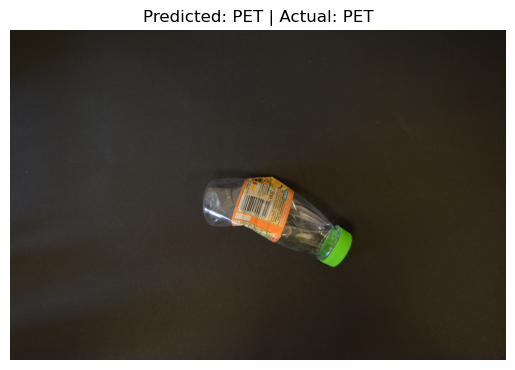

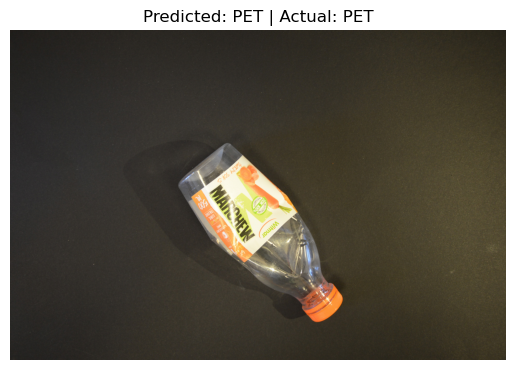

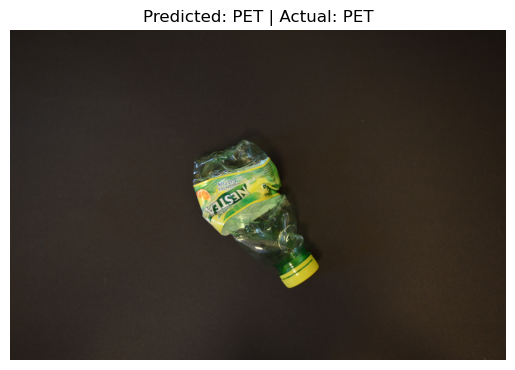

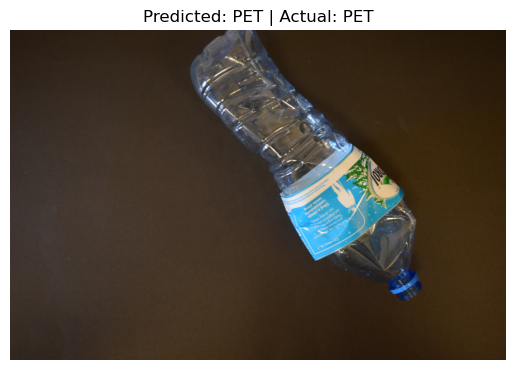

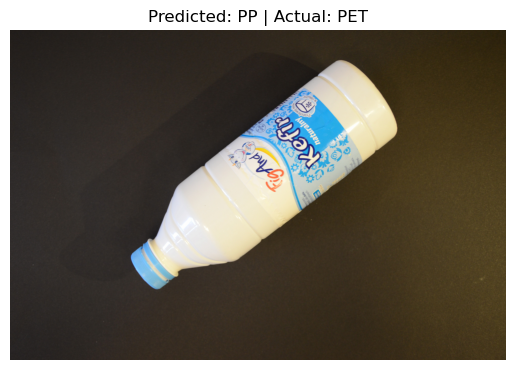

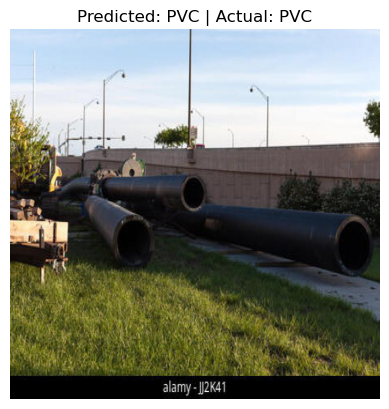

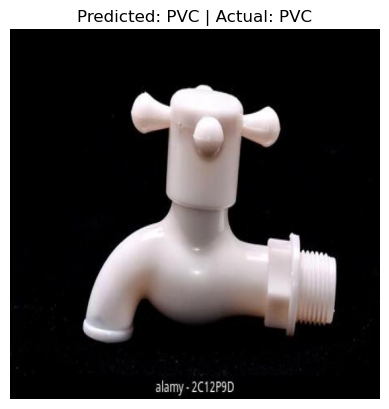

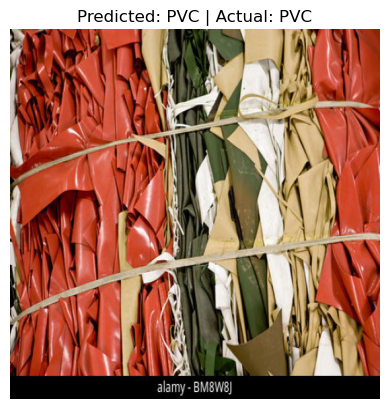

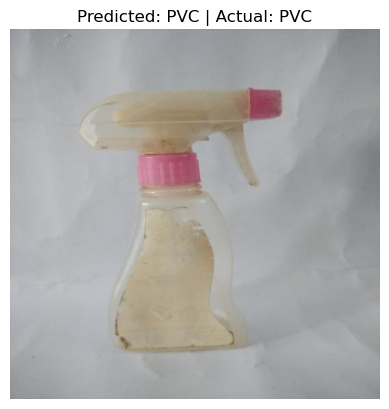

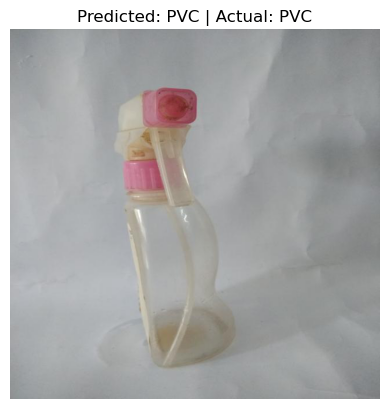

In [15]:
for class_folder in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_folder)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path)[:5]:  # Only show 10 per class
            image_path = os.path.join(class_path, image_name)
            predict_and_compare(
                image_path=image_path,
                model=model,
                class_names=class_names,
                transform=transform_eval,
                true_class=class_folder,
                device=device
            )